In [3]:
# https://www.tensorflow.org/tutorials/images/segmentation
# using tutorial to understand basics of UNet and Segmentation

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import array_to_img

import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info = True)

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/255.0 # cast sets dtype//changes pixel values from 0-255 to 0-1
    input_mask -= 1 # in this set, mask is labeled [1,2,3], -=1 sets to [0,1,2]
    return input_image, input_mask

In [7]:
def load_img(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask
# data preprocessing

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train_images = dataset['train'].map(load_img, num_parallel_calls = tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_img, num_parallel_calls = tf.data.AUTOTUNE)

# mapping a normalized image (in normalize function, called in loading function) creates pixel values [0,1]

In [10]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed = 42):
        super().__init__() # both use same seed to make same "random" change
        
        self.augment_inputs = preprocessing.RandomFlip(mode = 'horizontal', seed = seed)
        self.augment_labels = preprocessing.RandomFlip(mode = 'horizontal', seed = seed)
        
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        
        return inputs, labels
    
# data augmentation (might be easier w datagen)

In [11]:
train_batches = (train_images.cache().shuffle(BUFFER_SIZE)
                .batch(BATCH_SIZE).repeat().map(Augment())
                .prefetch(buffer_size = tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

# creating batches

In [16]:
def display(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
# funtion to display images & corresponding mask

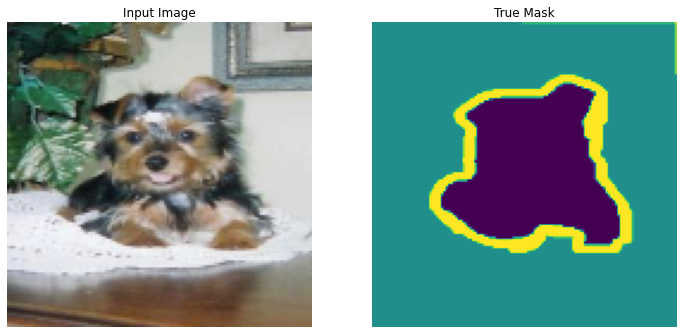

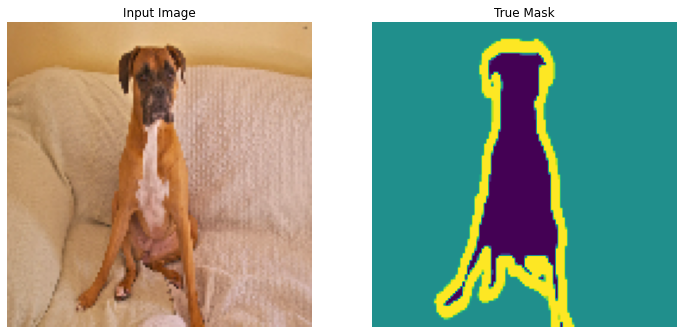

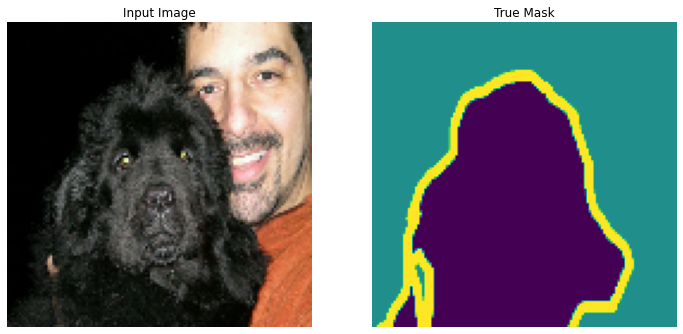

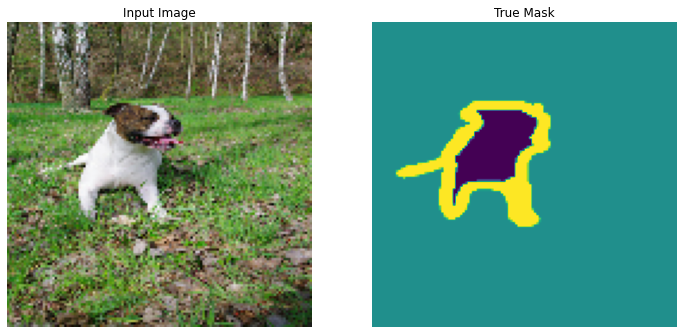

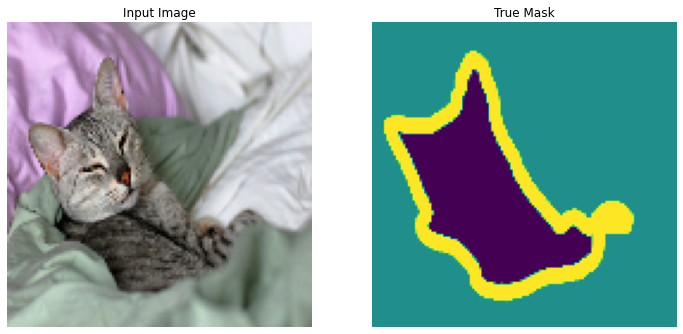

In [17]:
for images, masks in train_batches.take(5):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [19]:
# using modified UNet, with MobileNetV2 as base model/encoder

base_model = tf.keras.applications.MobileNetV2(input_shape = [128, 128, 3], include_top = False)

# activations of these layers w size in comment:
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project'      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# feature extraction model:
down_stack = tf.keras.Model(inputs = base_model.input, outputs = base_model_outputs)
down_stack.trainable = False

In [21]:
# decoder is using upsample blocks from pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [27]:
# defining unet model
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape = [128, 128, 3])
    
    # downsample:
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # upsample & establish skip connections:
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        
    # last layer:
    last = tf.keras.layers.Conv2DTranspose(
        filters = output_channels, kernel_size = 3, 
        strides = 2, padding = 'same') # 64x64 -> 128x128
    
    x = last(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [32]:
# compile
# the label assigned to the pixel is the channel with the highest value (create_mask function)

OUTPUT_CLASSES = 3

model = unet_model(output_channels = OUTPUT_CLASSES)
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy']
             )

In [34]:
# tf.keras.utils.plot_model(model, show_shapes = True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [35]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis = -1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [36]:
def show_predictions(dataset = None, num = 1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, 
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

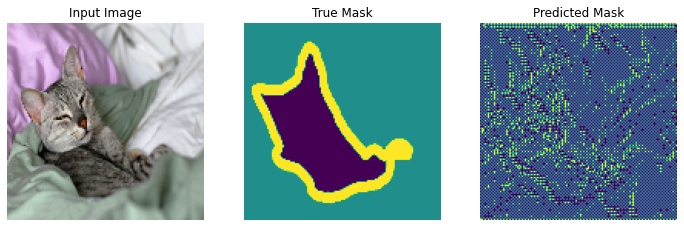

In [37]:
show_predictions() # prediction without training

In [38]:
# callbacks:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        clear_output(wait = True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

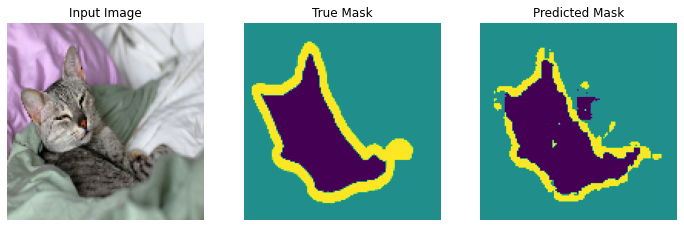


Sample Prediction after epoch 20



In [39]:
# training model
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

hist = model.fit( train_batches, epochs = EPOCHS,
                steps_per_epoch = STEPS_PER_EPOCH,
                validation_steps = VALIDATION_STEPS,
                validation_data = test_batches,
                callbacks = [DisplayCallback()])

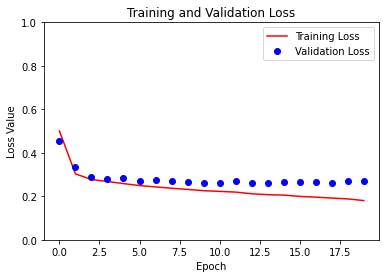

In [40]:
# plot history:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure()
plt.plot(hist.epoch, loss, 'r', label = 'Training Loss')
plt.plot(hist.epoch, val_loss, 'bo', label = 'Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

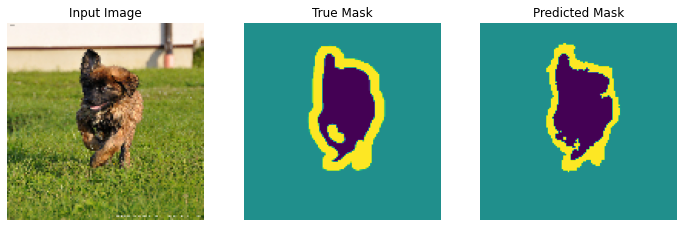

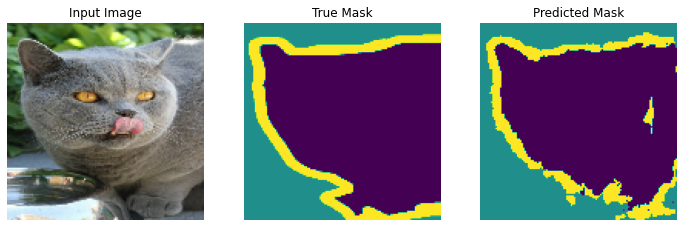

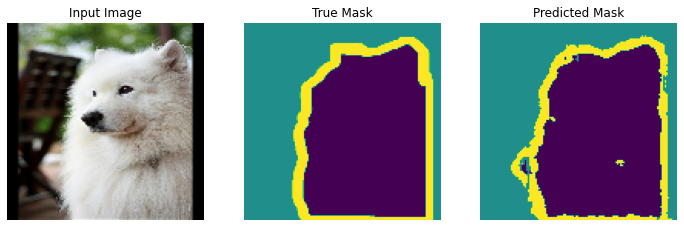

In [41]:
show_predictions(test_batches, 3)

In [46]:
model.evaluate(train_batches, steps = VALIDATION_STEPS)

11/11 [==============================] - 15s 1s/step - loss: 0.1779 - accuracy: 0.9212


[0.1778700351715088, 0.9212095737457275]

In [47]:
model.save('tfunetmod.h5') 

# /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: 
# CustomMaskWarning: Custom mask layers require a config and must override get_config. 
# When loading, the custom mask layer must be passed to the custom_objects argument. category=CustomMaskWarning)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
